In [1]:
import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggMapNet, loadmap


from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve

sns.set(style='white',  font='sans-serif', font_scale=2)  

def prc_auc_score(y_true, y_score):
    precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
    auc = calculate_auc(recall, precision)
    return auc

def get_non_diag_mean(df):
    v = df.values.copy()
    np.fill_diagonal(v, np.nan)
    mean =  pd.DataFrame(v, columns = df.columns, index = df.index).mean(axis=1).round(2)
    std = pd.DataFrame(v, columns = df.columns, index = df.index).std(axis=1).round(2)
    return mean.mean()

2022-09-24 14:52:30.598827: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dfx = pd.read_excel('./CRC.xlsx', sheet_name='data')
dfy = pd.read_excel('./CRC.xlsx', sheet_name='sample_info')
df_imp = pd.read_excel('./results/feature_importance.xlsx', index_col=0)
mp = loadmap('./model/aggmap.mp')


dfx = dfx[dfx.columns[1:]]
dfx = np.log(dfx + 1e-8)
dfy['Country'] = dfy.Country.map({'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'})

X_3D = mp.batch_transform(dfx.values, scale_method= 'standard')
X_lr = mp.transform_mpX_to_df(X_3D)

100%|#####################################################################################################################################| 575/575 [00:01<00:00, 304.81it/s]


In [3]:
y = pd.get_dummies(dfy['Group'])
Y = y.CRC.values

In [4]:
country_idx = dfy.groupby(['Country']).apply(lambda x:x.index.tolist())
country_names = country_idx.index.tolist()

In [5]:
#study to study transfer
asv = []
all_df = []
for top in [10, 15, 30, 40, 50, 60, 75, 100, 200, 300, 400, 'all']:
    
    if top == 'all':
        X = X_lr[mp.flist].values
        top = 849
    else:
        X = X_lr[df_imp.head(top).index].values
    run_all = []
    for train_country in country_names:

        train_idx = country_idx.loc[train_country]
        trainX = X[train_idx]
        trainY = Y[train_idx]
        clf = linear_model.LogisticRegression(C = 0.001, fit_intercept = False)
        clf.fit(trainX, trainY)
        for test_country in country_names:
            test_idx = country_idx.loc[test_country]
            testY = Y[test_idx]
            testX = X[test_idx]
            y_true = testY
            y_pred = clf.predict(testX)
            y_score = clf.predict_proba(testX)[:, 1]
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            acc = (tp + tn) / sum([tn, fp, fn, tp])
            sensitivity = tp / sum([tp, fn])
            specificity = tn / sum([tn, fp])
            prc_auc = prc_auc_score(y_true, y_score)
            roc_auc = roc_auc_score(y_true, y_score)
            precision = tp / sum([tp, fp])
            recall =  tp / sum([tp, fn]) #equals to sensitivity
            f1 = precision*recall*2/(precision + recall)
            res = {'Top_features': top, 
                   'train_country': train_country,
                   'test_country':test_country,
                   'accuracy':acc, 
                   'prc_auc':prc_auc, 
                   'roc_auc':roc_auc,
                   'sensitivity': sensitivity, 
                   'specificity': specificity,
                   'precision':precision,
                   'recall':recall,
                   'f1': f1
                  }
            run_all.append(res)

    dfres = pd.DataFrame(run_all)
    dfres = dfres[dfres.train_country != dfres.test_country]
    
    average = dfres.mean().round(3).to_dict()
    
    dfres = dfres.set_index(['train_country', 'test_country'])
    all_df.append(dfres)
    asv.append(average)

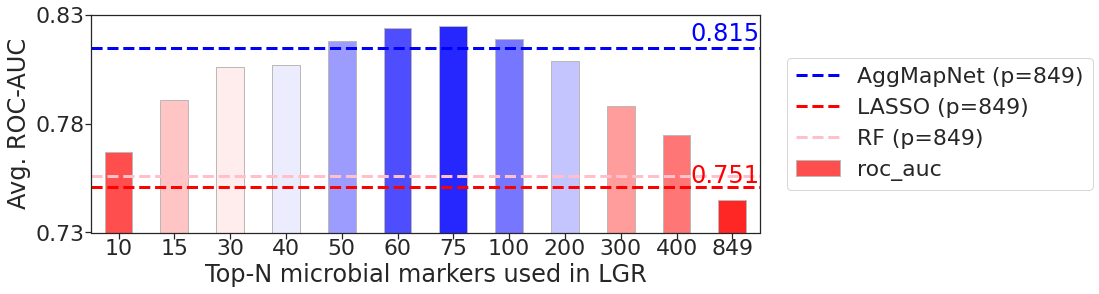

In [48]:
color = sns.color_palette("bwr",12) #PiYG

fig, ax  = plt.subplots(1, 1, figsize=(12, 4))
dfp1 = pd.DataFrame(asv).set_index('Top_features')

dfp1 = dfp1.sort_values('roc_auc',ascending=False)
dfp1['color'] = color

dfp1 = dfp1.sort_index()

dfp1.index = dfp1.index.astype(int)
#color = pd.Series(color.as_hex(), index = dfp1.roc_auc).sort_index().to_list()

dfp1.roc_auc.plot(kind='bar', ax=ax, color = dfp1.color, edgecolor='#bcb8b6', width = 0.5)
ax.set_ylim(0.73, 0.83)

ax.set_yticks([0.73, 0.78, 0.83])

ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)


plt.xticks(rotation=0, )

ax.set_ylabel('Avg. ROC-AUC')

ax.set_xlabel('Top-N microbial markers used in LGR')

ax.axhline(y=0.815, color='blue', ls='--', lw = 3, label = 'AggMapNet (p=849)')
ax.axhline(y=0.751, color='red', ls='--', lw = 3, label = 'LASSO (p=849)')
ax.axhline(y=0.756, color='pink', ls='--', lw = 3, label = 'RF (p=849)')
#ax.axhline(y=0.745, color='red', ls='--', lw = 3, label = 'LGR (p=849)')

ax.text(10.25, 0.818, '0.815', color='blue')
ax.text(10.25, 0.753, '0.751', color='red')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.savefig('./results/topN_LGR.pdf', dpi = 400, bbox_inches="tight")

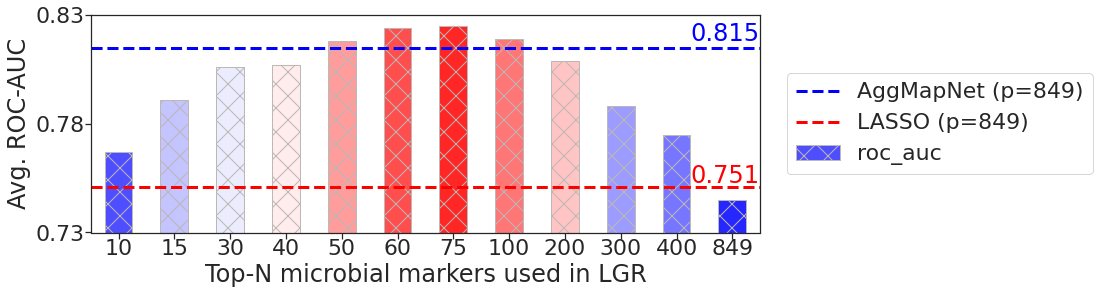

In [7]:
color = sns.color_palette("bwr_r",12) #PiYG

fig, ax  = plt.subplots(1, 1, figsize=(12, 4))
dfp1 = pd.DataFrame(asv).set_index('Top_features')

dfp1 = dfp1.sort_values('roc_auc',ascending=False)
dfp1['color'] = color

dfp1 = dfp1.sort_index()

dfp1.index = dfp1.index.astype(int)
#color = pd.Series(color.as_hex(), index = dfp1.roc_auc).sort_index().to_list()

dfp1.roc_auc.plot(kind='bar', ax=ax, color = dfp1.color, hatch = 'x', edgecolor='#bcb8b6', width = 0.5)
ax.set_ylim(0.73, 0.83)

ax.set_yticks([0.73, 0.78, 0.83])

ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)


plt.xticks(rotation=0, )

ax.set_ylabel('Avg. ROC-AUC')

ax.set_xlabel('Top-N microbial markers used in LGR')

ax.axhline(y=0.815, color='blue', ls='--', lw = 3, label = 'AggMapNet (p=849)')
ax.axhline(y=0.751, color='red', ls='--', lw = 3, label = 'LASSO (p=849)')

ax.text(10.25, 0.818, '0.815', color='blue')
ax.text(10.25, 0.753, '0.751', color='red')

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [8]:
dfp1

,accuracy,prc_auc,roc_auc,sensitivity,specificity,precision,recall,f1,color
Top_features,,,,,,,,,
10,0.731,0.821,0.767,0.548,0.907,0.855,0.548,0.665,"(0.3058823529411765, 0.3058823529411765, 1.0)"
15,0.729,0.827,0.791,0.548,0.907,0.857,0.548,0.664,"(0.7686274509803921, 0.7686274509803921, 1.0)"
30,0.719,0.825,0.806,0.528,0.908,0.855,0.528,0.647,"(0.9254901960784314, 0.9254901960784314, 1.0)"
40,0.719,0.826,0.807,0.541,0.898,0.843,0.541,0.652,"(1.0, 0.9254901960784314, 0.9254901960784314)"
50,0.731,0.834,0.818,0.565,0.896,0.846,0.565,0.671,"(1.0, 0.611764705882353, 0.611764705882353)"
60,0.742,0.836,0.824,0.595,0.884,0.842,0.595,0.690,"(1.0, 0.3058823529411765, 0.3058823529411765)"
75,0.743,0.834,0.825,0.613,0.868,0.826,0.613,0.698,"(1.0, 0.14901960784313725, 0.14901960784313725)"
100,0.744,0.828,0.819,0.652,0.828,0.796,0.652,0.712,"(1.0, 0.4627450980392157, 0.4627450980392157)"
200,0.727,0.819,0.809,0.699,0.747,0.746,0.699,0.715,"(1.0, 0.7686274509803921, 0.7686274509803921)"


In [9]:
metric = "roc_auc"

dfp = pd.concat(all_df).reset_index()
dfp['Cross'] = dfp.train_country + '->' + dfp.test_country
dfp = dfp.set_index(['Top_features', 'Cross'])[metric].reset_index()
dfp['model']  = 'LGR'
dfp

,Top_features,Cross,roc_auc,model
0,10,AUS->CHN,0.760511,LGR
1,10,AUS->DEU,0.786389,LGR
2,10,AUS->FRA,0.770028,LGR
3,10,AUS->USA,0.665865,LGR
4,10,CHN->AUS,0.825742,LGR
...,...,...,...,...
235,849,FRA->USA,0.723003,LGR
236,849,USA->AUS,0.645618,LGR
237,849,USA->CHN,0.752002,LGR
238,849,USA->DEU,0.783333,LGR


In [10]:
y = """train_country	test_country	roc_auc
FRA	DEU	0.831666667
FRA	CHN	0.826576577
FRA	USA	0.642381657
FRA	AUS	0.768806073
DEU	FRA	0.84441695
DEU	CHN	0.877877878
DEU	USA	0.743713018
DEU	AUS	0.777777778
CHN	FRA	0.825549026
CHN	DEU	0.830833333
CHN	USA	0.669378698
CHN	AUS	0.764665286
USA	FRA	0.751005258
USA	DEU	0.788888889
USA	CHN	0.696946947
USA	AUS	0.777432712
AUS	FRA	0.628518404
AUS	DEU	0.651944444
AUS	CHN	0.741991992
AUS	USA	0.589497041""" 
pres = [i.split('\t') for i in y.split('\n')]

lasso_df = pd.DataFrame(pres[1:], columns=pres[0])
lasso_df['roc_auc'] = lasso_df['roc_auc'].astype('float')

lasso_df['Cross'] = lasso_df.train_country + '->' + lasso_df.test_country
lasso_df['Top_features'] = 849
lasso_df['model'] = 'LASSO'
lasso = lasso_df[dfp.columns]

In [11]:
agg_df = pd.read_excel('./results/study2study_results_ROC.xlsx',index_col='train_country')

agg_df = agg_df.rename(columns = {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'},
                    index =  {'AUS':"AUS", 'CHI':'CHN', 'FRA':'FRA', 'GER':'DEU', 'USA':'USA'}
                    )

agg_df = agg_df.unstack().reset_index()
agg_df.columns = ['test_country', 'train_country', 'roc_auc']
agg_df = agg_df[agg_df.test_country != agg_df.train_country]
agg_df['Cross'] = agg_df.train_country + '->' + agg_df.test_country
agg_df['Top_features'] = 849
agg_df['model'] = 'AggMapNet'
aggmapnet = agg_df[dfp.columns]

In [30]:
rf = pd.read_csv('./marker_old_methods/rf.csv', index_col=0)

In [32]:
dfp = dfp.append(aggmapnet.append(lasso).append(rf)).reset_index(drop=True)
dfp['model2'] = dfp.model + '-Top'+ dfp.Top_features.astype(str)
dfp.model2.unique()

array(['LGR-Top10', 'LGR-Top15', 'LGR-Top30', 'LGR-Top40', 'LGR-Top50',
       'LGR-Top60', 'LGR-Top75', 'LGR-Top100', 'LGR-Top200', 'LGR-Top300',
       'LGR-Top400', 'LGR-Top849', 'AggMapNet-Top849', 'LASSO-Top849',
       'RF-Top849'], dtype=object)

In [39]:
hue_order = ['LGR-Top849', 'LASSO-Top849' , 'RF-Top849',  'LGR-Top10', 'LGR-Top15',  'AggMapNet-Top849', 'LGR-Top50', 'LGR-Top75', ]
order = dfp[dfp.model2.isin(hue_order)].groupby(['Cross']).roc_auc.mean().sort_values().index

In [38]:
dfp2 = pd.pivot_table(dfp, index = 'model2',columns = 'Cross', values='roc_auc', aggfunc = np.mean)
dfp2 = dfp2.loc[hue_order][order]

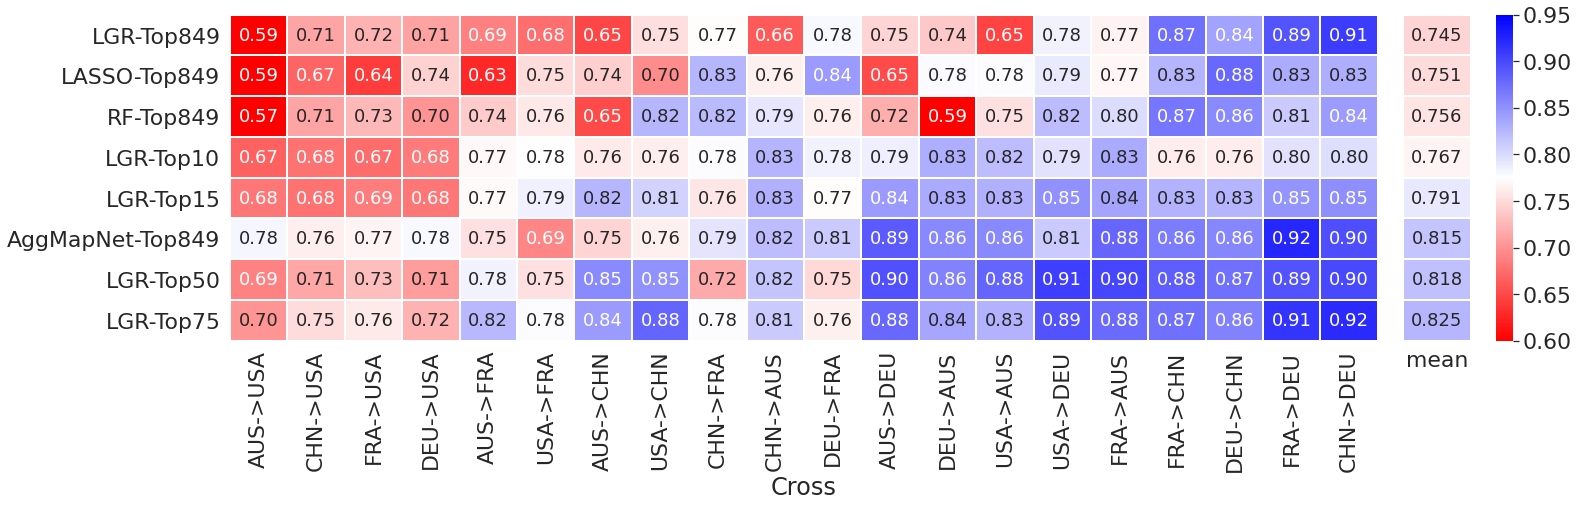

In [42]:
fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(23, 6),  gridspec_kw={'width_ratios': [20, 1.2, 0.3]}, sharey=False, )

vmin = 0.60
vmax = 0.95

sns.heatmap(dfp2, cmap = 'bwr_r', ax=ax1, annot=True,  vmin = vmin, linewidths=.1, cbar_ax = ax3, fmt='.2f',
            vmax = vmax, annot_kws={"fontsize":18}, cbar=True)

sns.heatmap(dfp2.mean(axis=1).to_frame(name='mean'), cmap = 'bwr_r', ax=ax2, annot=True, linewidths=.1,fmt='.3f',
            
            vmin = vmin, vmax = vmax, annot_kws={"fontsize":18}, cbar=False)

ax2.set_yticklabels([])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.06, hspace=None)

ax2.set_ylabel('')
ax1.set_ylabel('')


plt.savefig('./results/AggMapNet_LASSO_LGR_RF_key_marker.pdf', dpi = 400, bbox_inches="tight")

In [26]:
# color = sns.color_palette("rainbow_r",5) #PiYG

# color
# hue = 'model2'

# fig, ax  = plt.subplots(1, 1, figsize=(14, 4))
# g = sns.pointplot(x ="Cross" , y = metric,  hue = hue, 
#                   hue_order = hue_order, order = order,
#                   data=dfp, lw=2, #markers=['o', 's', 'x', '>'], 
#                   s=100, alpha=1, style='Top_features',
#                   ax=ax,  palette=color, ) #legend=False,

# ax.tick_params(axis='y', left='off', labelleft='on', pad=.3,)
# ax.tick_params(axis='x', bottom='off', labelleft='on', pad=.3,)

# #ax.locator_params(nbins=5)

# #g.legend_.remove()

# #ax.set_xticks([0.55, 0.75, 0.95])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax.set_ylabel('')

# plt.xticks(rotation=90, ha = 'center')

# #plt.savefig('./fig/4_corr.pdf', dpi = 400, bbox_inches="tight")